# Exponential Comparisons
step1: pds(emp power)
step2: theoretical exp. dist
step3: compare two distributions

In [1]:
cd ..

/Users/rdgao/Documents/code/research/spectralCV


In [2]:
import sys
sys.path.append('/Users/rdgao/Documents/code/research/neurodsp/')
sys.path.append('/Users/rdgao/Documents/code/research/spectralCV/')

In [3]:
from scv_funcs import access_nt as asc
import numpy as np

In [4]:
#data_path ="/Users/Lauren/Data/NeuroTycho/anesthesia/20120730PF_Anesthesia+and+Sleep_Chibi_Toru+Yanagawa_mat_ECoG128/Session%d/"
data_path ="/Users/rdgao/Documents/data/NeuroTycho/Propofol/20120730PF_Anesthesia+and+Sleep_Chibi_Toru+Yanagawa_mat_ECoG128/Session%d/"
session = 1
chan = [1,2,3,4] # start at 1

# with specified indices
indices = [0,0]
data = asc.get_ECoG(data_path, session, chan, indices)

In [5]:
import neurodsp as ndsp
import matplotlib.pyplot as plt
%matplotlib inline

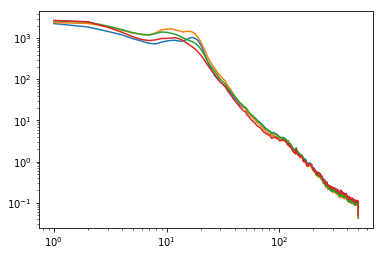

In [6]:
fs = 1000
nperseg = 1000
noverlap = nperseg/2
f, psd_ = ndsp.spectral.psd(data, Fs=fs, nperseg=nperseg, noverlap=noverlap)
#_, _, spg_ =
plt.loglog(f,psd_[0:,:].T);

Text(0.5,1,'Frequency=100.0 Hz')

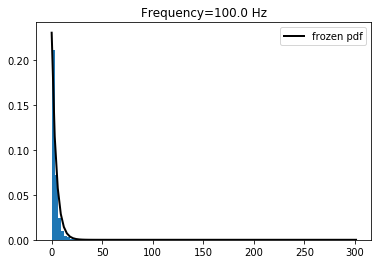

In [7]:
from scipy.stats import expon
import scipy as sp
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
mean, var, skew, kurt = expon.stats(moments='mvsk')
y = np.arange(1,50)
#ax.plot(x, expon.pdf(x),'r-', lw=5, alpha=0.6, label='expon pdf')
#_ = ax.plot(psd_[0][:100])
# _ = ax.plot(psd_[1])

fs = 1000
nperseg = 1000
noverlap = 0
freq_ind = 100
num_bins = 100

f_axis_, t_axis_, spg_ = sp.signal.spectrogram(data[0],fs=fs,nperseg=nperseg,noverlap=noverlap)
_, scale_ = sp.stats.expon.fit(spg_[freq_ind],floc=0)
hists = ax.hist(spg_[freq_ind],normed=True,bins=num_bins)
x = hists[1]
#x = np.linspace(0,500, 1000)
#ax.plot(x, expon.pdf(x),'r-', lw=5, label='expon pdf')
rv = expon(scale = scale_)
ax.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf',)
#plt.xlim(0,250)
#plt.ylim(0,0.0005)
plt.legend()
plt.title('Frequency=%.1f Hz' %f[freq_ind])

### KS statistic

In [66]:
#def fit_exp_to_spg(spg_):
pvals = np.zeros((len(spg_)))
statistics = np.zeros((len(spg_)))

for i in range(len(spg_)):
    param = sp.stats.expon.fit(spg_[i], floc=0)
    #    stat, pval = sp.stats.kstest(x, lambda x : sp.stats.expon.cdf(x, *param))
    stat, pval = sp.stats.kstest(spg_[i], 'expon', args=param)
    pvals[i] = pval
    statistics[i] = stat
#    return pvals, statistics

In [67]:
statistics[50]

0.029416937667963938

#### Plotting

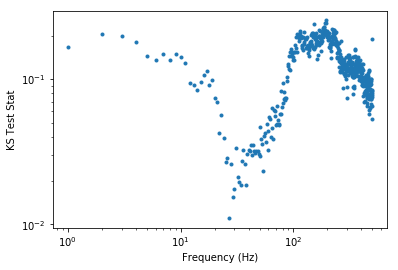

In [16]:
# expon
_ = plt.loglog(f, statistics,'.')
plt.xlabel('Frequency (Hz)')
plt.ylabel('KS Test Stat');

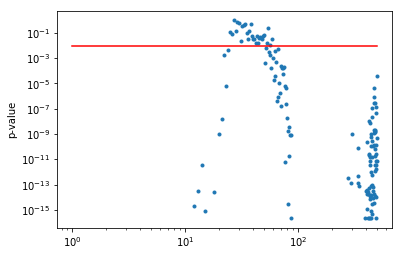

In [17]:
# expon
_ = plt.loglog(f,pvals,'.')
plt.plot(f, np.ones(len(f))*0.01, 'r-')
plt.ylabel('p-value');

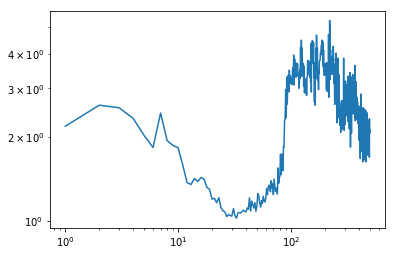

In [18]:
plt.loglog(f,np.std(spg_,axis=1)/np.mean(spg_,axis=1))

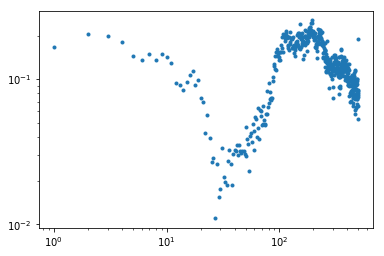

In [19]:
#lambda
_ = plt.loglog(statistics,'.')

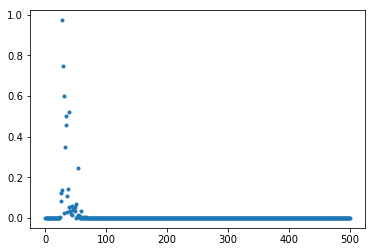

In [20]:
#lambda without loglog
_ = plt.plot(pvals,'.')

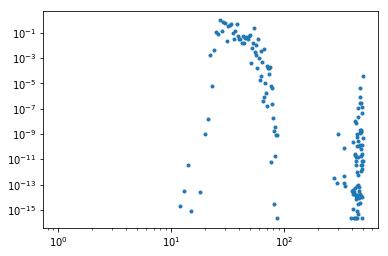

In [21]:
#lambda with loglog
_ = plt.loglog(pvals,'.')

### Monte Carlo

Monte Carlo procedure:
1. Compute param (lambda) for exponential dist using data
2. Draw N points from exponential dist parametrized by lambda
3. Compute KS statistic for simulated data against theoretical
4. Do 2 and 3 M times, get distribution of test-statistic values to build distribution
5. Compare your KS statistic of your data against theoretical distribution
6. Get p-value from t-val distributions 


In [31]:
_, scale_ = sp.stats.expon.fit(spg_[2],floc=0)

In [38]:
len(spg_[i])

1929

In [52]:
?sp.stats.kstat

In [53]:
?sp.stats.kstest #first param is an array; 

In [59]:
len([x for x in np.asarray([1,2,3]) if x < 3])

2

In [8]:
def MC_KS_exp(x, N_draws, N_samples=None, do_sims=False):

    # if N_samples is not given, default to same number as # of power values
    if N_samples is None:
        N_samples = len(x)
        
    # initialize test statistic array
    sim_statistics = np.zeros((N_draws))
    
    # fit theoretical dist to data, get one set of params
    obs_param = sp.stats.expon.fit(x, floc=0)
    
    # compute empirical ks-test statistic and p-val on data
    obs_stat, obs_pval = sp.stats.kstest(x, 'expon', args=obs_param)
    
    if do_sims:
        # perform MC sim
        for n in range(N_draws):
            # draw from theoretical distribution
            simulated = np.random.exponential(scale=obs_param[1],size=N_samples)

            # test randomly drawn data against theoretical for statistic and p-val
            stat, pval = sp.stats.kstest(simulated, 'expon', args=obs_param)
            sim_statistics[n] = stat
        
        # find simulated p-value
        sim_pval = len([s for s in sim_statistics if s>obs_stat])/N_draws
    else:
        sim_pval = np.nan
        sim_statistics = np.nan*np.ones((N_draws))

    return obs_stat, obs_pval, sim_pval, sim_statistics

In [15]:
f_axis_, t_axis_, spg_ = sp.signal.spectrogram(data[0],fs=fs,nperseg=nperseg,noverlap=noverlap)
i = 50
spg_slice = spg_[i]
# number of random varaibles
Nx = 1900
# number of times wish to simulate
N = 10000
emp_stat, emp_p, sim_p, sim_stat = MC_KS_exp(x=spg_slice, N_draws=N,N_samples=None, do_sims=True)
print('Simulated P-Val:', sim_p)
print('Point-estimate P-Val:', emp_p)

Simulated P-Val: 0.0683
Point-estimate P-Val: 0.0695805575713


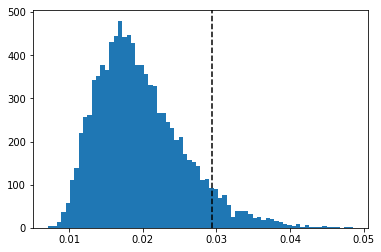

In [16]:
plt.hist(sim_stat,bins=70)
plt.axvline(x=emp_stat,color='k',ls='--')
plt.show()
plt.close()

In [20]:
def spg_mc_KSexp(spg, N_draws=1000, N_samples=None, do_sims=False):
    N_freqs, N_data = spg.shape
    if N_samples is None:
        N_samples = N_data

    # init vectors
    p_sims = np.zeros(N_freqs)
    p_emp = np.zeros(N_freqs)
    t_emp = np.zeros(N_freqs)

    for i in range(N_freqs):
        t_emp[i], p_emp[i], p_sims[i], sim_stat = MC_KS_exp(spg_[i,:],N_draws=N_draws,N_samples=N_samples, do_sims=do_sims)
        
    return p_sims, p_emp, t_emp

Frequencies failed to reject: [ 20.  22.  23.  24.  25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.
  36.  37.  38.  39.  41.  42.  44.  46.  48.  49.  55.]


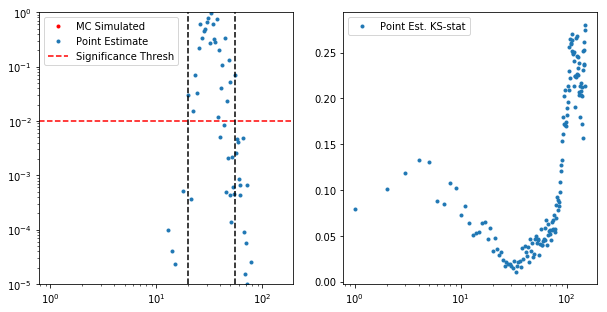

In [35]:
f_axis_, t_axis_, spg_ = sp.signal.spectrogram(data[2],fs=fs,nperseg=nperseg,noverlap=noverlap)

sig_thres = 0.01
# define some threshold frequency that we want to stop at
f_max = 150.
f_inds = np.where(f_axis_<=f_max)[0]
p_sims, p_emp, t_emp = spg_mc_KSexp(spg_[f_inds,:], 1000)
sig_zone = f_axis_[f_inds][np.where(p_emp>sig_thres)[0]]

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.loglog(f_axis_[f_inds],p_sims,'r.', label='MC Simulated')
plt.loglog(f_axis_[f_inds],p_emp,'.', label='Point Estimate')
plt.axhline(y=sig_thres,color='r',ls='--', label='Significance Thresh')
plt.axvline(x=sig_zone[0],color='k',ls='--')
plt.axvline(x=sig_zone[-1],color='k',ls='--')
plt.ylim([1e-5, 1])
plt.legend()

plt.subplot(1,2,2)
plt.semilogx(f_axis_[f_inds], t_emp, '.', label='Point Est. KS-stat')
plt.legend()
print('Frequencies failed to reject:', f_axis_[f_inds][np.where(p_emp>sig_thres)[0]])

#### chicken scratch work

(array([  2.22946313e-03,   5.01271154e-05,   1.49187843e-05,
          3.58050824e-06,   1.19350275e-06,   5.96751374e-07,
          0.00000000e+00,   0.00000000e+00,   5.96751374e-07,
          1.19350275e-06]),
 array([  1.91211291e-09,   4.34467139e+02,   8.68934277e+02,
          1.30340142e+03,   1.73786855e+03,   2.17233569e+03,
          2.60680283e+03,   3.04126997e+03,   3.47573711e+03,
          3.91020425e+03,   4.34467139e+03]),
 <a list of 10 Patch objects>)

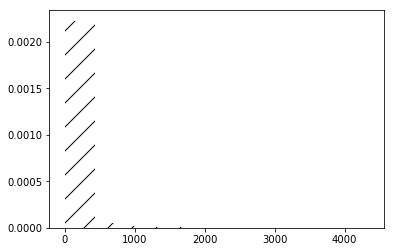

In [103]:
x = spg_[0]
param = sp.stats.expon.fit(x)
plt.hist(x, normed=True, color='white', hatch='/')